# calcanoms 

This is the second step in getting atmospheric river stuff

This program:
1. Calculates the seasonal cycle for the NDJFM AR occurrence data
* Input File: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.nc`
* Seasonal cycle is calculated using David Straus's parabola method
* Fit a parabola at each grid point over all days in the season for each year
* Average the parabola at each grid point over all years, this is the climatological seasonal cycle
    - Output File: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.climo.nc`
2. Calculates the anomalies
* By removing the climatological seasonal cycle from the full fields
3. Writes anomalies to a single netcdf file
* Output File: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.anoms.nc`

### Function to calculate the climatology using the parabola fit method

In [1]:
def climo_parabola(da):
  
    nt,ny,nx=da.shape
    print(da.shape)
    nyr = 30 #number of years
    ndays = int(nt/nyr) #number of times
    print(ndays)
    
    
    poly=np.zeros((nyr,ndays,ny,nx))
    x=np.arange(ndays) #days
    y=da.reshape(nyr,ndays,nx*ny) #reshape input array to have (number of years, days, grid points), new dataset
    
    #Fit parabola to each year
    for iyr in range(nyr):
        pfitcoeffs=np.polyfit(x,y[iyr,:,:],3)
        #print(nyr)
        #print(pfitcoeffs)
    
        k=0
        for j in range(ny):
            for i in range(nx):
                poly[iyr,:,j,i]=np.polyval(pfitcoeffs[:,k],x)
                k+=1
    
    #Take the mean of all the parabolas
    climo=poly.mean(axis=0)
    
    return climo

### Function to remove the climatology from the data to get anomalies

In [2]:
def make_anoms(da,climo):

    nt,ny,nx=da.shape
    nyr = 30 #number of years
    ndays = int(nt/nyr) #number of times
    y=da.reshape(nyr,ndays,ny,nx) #reshaped data set

    anoms=np.zeros((nyr,ndays,ny,nx)) #anomaly data set
    
    #Subtract the climatology from the data
    for iyr in range(nyr):
        anoms[iyr,:,:,:]=y[iyr,:,:,:]-climo 
        
    anoms=anoms.reshape(nt,ny,nx)
    
    return anoms

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Constants

In [4]:
era5 = True
res = '1279'
resolution = 'tco' + res
threshold = '10%'

### Define input and output files

In [5]:
# Path
if era5 == True or res == '199':
    path='/glade/work/mkorendy/metisregimes/'
else:
    path = '/glade/work/mkorendy/metisregimes/' + resolution + '/'
    
# Atmospheric River Input
if era5 == True:
    fname = path + 'era5.AR.' + threshold + '.PNA.NDJFM.nc'
elif res == '1279':
    fname= path + 'metis1279.AR.' + threshold + '.PNA.ND.nc'
else:
    fname = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.nc'
    
# Filter time input
if era5 == True or res != '1279':
    f_times = '/glade/work/mkorendy/metisregimes/' + 'metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.anoms.nc'
else:
    f_times = path + 'metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.anoms.nc'

# Output
if era5 == True:
    clim_out = path + 'era5.AR.' + threshold + '.PNA.NDJFM.climo.nc'
    anoms_out = path + 'era5.AR.' + threshold + '.PNA.NDJFM.anoms.nc'
elif res == '1279':
    clim_out = path + 'metis1279.AR.' + threshold + '.PNA.ND.climo.nc'
    anoms_out = path + 'metis1279.AR.' + threshold + '.PNA.ND.anoms.nc'
else:
    clim_out = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.climo.nc'
    anoms_out = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.anoms.nc'

In [6]:
print(fname)
print(clim_out)
print(anoms_out)
print(f_times)

/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.nc
/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.climo.nc
/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc
/glade/work/mkorendy/metisregimes/metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.anoms.nc


### Set the list of years

In [7]:
yrs_list=np.arange(1986,2016)

## Read the data

In [8]:
# Read data
ds=xr.open_dataset(fname,decode_times=True)

# Times
ds_times = xr.open_dataset(f_times, decode_times=True)

# Reorder data
if era5 == True:
    ds = ds.reindex(time=sorted(ds['time'].values))

# Select filtering dates
if era5 == True:
    ds = ds.sel(time=ds_times.time)

In [9]:
#ds

### Replace numbers with 1 and nans with 0 for better counting

In [10]:
da_river = np.nan_to_num(ds.river.values)
da_river = np.where(da_river == 0, 0, 1)

In [11]:
np.count_nonzero(da_river)

31429

### Reshape the metis data into ensembles and time

In [12]:
if era5 == False:
    ds = xr.DataArray(da_river.reshape((len(ds_times.ensemble), len(ds_times.time),22,53)), 
                     coords={'ensemble':ds_times.ensemble.values, 'time':ds_times.time.values, 
                             'lat':ds['lat'].values, 'lon':ds['lon'].values},
                             dims=['ensemble','time', 'lat', 'lon']).to_dataset(name='river')
else:
    ds = xr.DataArray(da_river.reshape(len(ds_times.time),22,53), 
                     coords={'time':ds_times.time.values, 
                             'lat':ds['lat'].values, 'lon':ds['lon'].values},
                             dims=['time', 'lat', 'lon']).to_dataset(name='river')

In [13]:
#ds

## Calculate climatology

In [14]:
if era5 == False:
    #Loop through ensembles
    climo = []
    #anoms_z500 = []

    for e in ds.ensemble:
        climo_e=climo_parabola(ds.sel(ensemble=e).river.values)
        climo.append(climo_e)

        #anoms_z500_e=make_anoms(ds.sel(ensemble=e)['low_pass_' + variable].values,climo_z500_e)
        #anoms_z500.append(anoms_z500_e)


    climo = np.array(climo)
    #anoms_z500 = np.array(anoms_z500)
    #print(climo.shape)
    #print(anoms_z500.shape)

    #climo_u250=climo_parabola(ds['u250'].values)
else:
    climo = climo_parabola(ds.river.values)

(8160, 22, 53)
272


In [15]:
climo.shape

(272, 22, 53)

In [16]:
if era5 == False:
    climo = xr.DataArray(climo, coords={'ensemble':ds.ensemble.values, 'time':np.arange(0,len(ds.time)/30),
                                        'lat':ds['lat'].values,'lon':ds['lon'].values},
                         dims=['ensemble','time','lat','lon'])
else:
    climo = xr.DataArray(climo, coords={'time':np.arange(0,272),
                                        'lat':ds['lat'].values,'lon':ds['lon'].values},
                         dims=['time','lat','lon'])

### The climatology is the seasonal cycle ensemble mean

In [17]:
if era5 == False:
    climo = climo.mean(dim='ensemble')

In [19]:
#ds.ensemble

## Calculate anomalies

In [20]:
if era5 == False:
    anoms = []

    for e in ds.ensemble.values:
        anoms_e=make_anoms(ds.sel(ensemble=e).river.values,climo)
        anoms.append(anoms_e)

    anoms = np.array(anoms)
else:
    anoms = make_anoms(ds.river.values,climo)
anoms.shape

(8160, 22, 53)

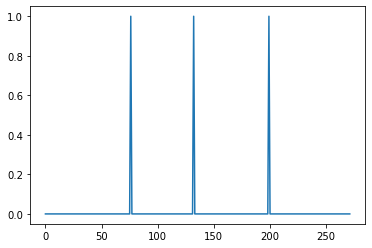

In [21]:
plt.plot(da_river[0:272,12,25])
#plt.plot(climo[:,12,25])
#plt.legend(['river','climo'])

In [22]:
#da_river[200:272]

In [23]:
if era5 == False:
    ds_anoms=xr.DataArray(anoms,
                    coords={'ensemble':np.arange(len(ds['ensemble'])), 'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                            dims=['ensemble','time','lat','lon'])
    ds_anoms=ds_anoms.to_dataset(name='river')
    ds_anoms = ds_anoms.transpose('time','ensemble','lat','lon')
else:
    ds_anoms = xr.DataArray(anoms,
                    coords={'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                            dims=['time','lat','lon'])
    ds_anoms=ds_anoms.to_dataset(name='river')

In [24]:
#ds_anoms

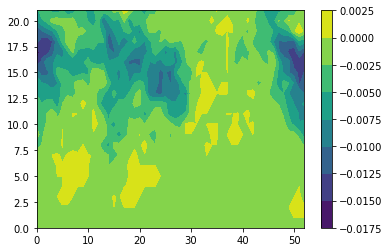

In [26]:
plt.contourf(ds_anoms.river[6,:,:])
plt.colorbar()

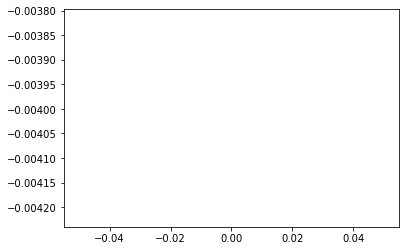

In [27]:
plt.plot(ds_anoms['river'][0,12,25])

In [28]:
climo = climo.to_dataset(name='river_clim')

### Write to netcdf

In [29]:
climo.to_netcdf(clim_out)
ds_anoms.to_netcdf(anoms_out)